# Forest Cover Type Prediction
#### Team: Clear-Cut Solution: Kevin Martin, Yang Jing, Justine Schabel

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Libraries for reading, cleaning and plotting the dataa
import numpy as np 
import pandas as pd 
import csv
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler


## Data Engineering

### Load Data

In [2]:
# Read in training data 
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv", nrows=30000)

### Initial Data Exploration

First, we split the training data into a training data set (80%) and development data set (20%). We will also have a large, separate test data set. 

In [3]:
# Split training data (labeled) into 80% training and 20% dev) and randomly sample 
training_data = train_df.sample(frac=0.8)
dev_data_df = train_df.drop(training_data.index)

# Examine shape of both data sets
print(training_data.shape)
print(dev_data_df.shape)

# Briefly examine feature attributes for the training data 
training_data.describe()

(12096, 56)
(3024, 56)


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,...,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000
mean,7546.534226,2746.369874,157.090939,16.519345,226.423611,50.986524,1703.771908,212.645916,218.956019,135.115989,...,0.046379,0.041171,0.001405,0.006531,0.000413,0.001819,0.048446,0.042576,0.030258,3.999917
std,4372.991866,417.621872,110.111541,8.481000,208.970686,61.169339,1320.758160,30.633664,22.815924,45.949645,...,0.210313,0.198693,0.037464,0.080554,0.020328,0.042610,0.214715,0.201908,0.171303,1.993561
min,1.000000,1874.000000,0.000000,0.000000,0.000000,-134.000000,0.000000,0.000000,99.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3758.750000,2372.000000,65.000000,10.000000,67.000000,5.000000,758.500000,196.000000,207.000000,106.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7537.500000,2749.000000,126.000000,15.000000,180.000000,32.000000,1308.000000,220.000000,223.000000,138.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,11343.250000,3098.000000,261.000000,22.000000,330.000000,79.000000,2250.000000,235.000000,235.000000,167.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,15120.000000,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


Now, we'll isolate and explore the distribution of soil types. 

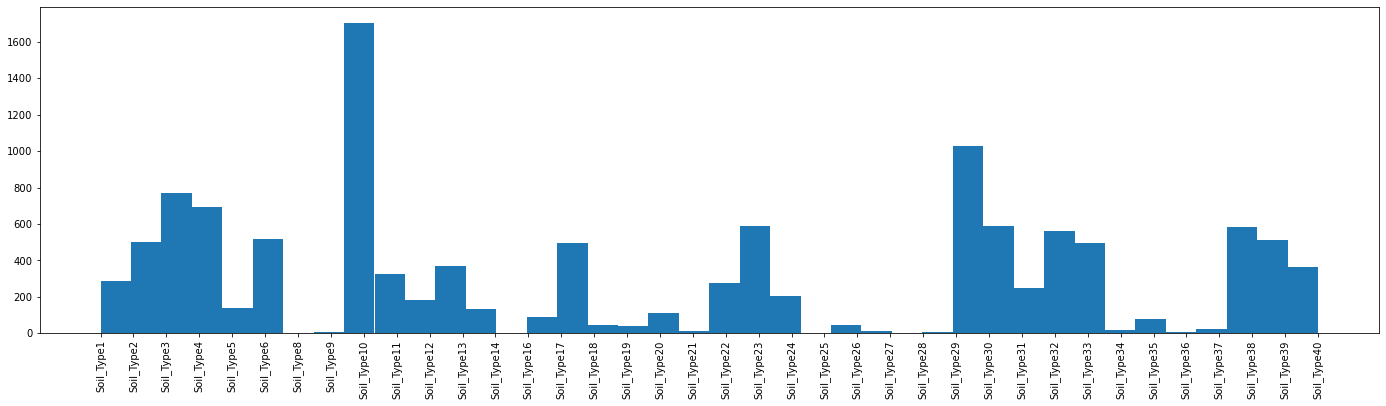

In [4]:
# Isolate soil type column names
soil_df = training_data[["Id",'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']]

# Now we convert the soil type columns back into one column with values as the "soil type"
soil_df_unpivoted = soil_df.melt(id_vars="Id",var_name="soil_type",value_name="yes")
mask1 = soil_df_unpivoted["yes"] ==1 #only keep rows of where the "soil type" is "yes"
soil_df_unpivoted = soil_df_unpivoted[mask1]


# Examine the fequencies of soil types
soil_df_unpivoted["soil_type"].value_counts().to_frame() 

# Histogram of soil types 
plt.figure(figsize=(24,6))
plt.hist(soil_df_unpivoted["soil_type"],bins=40)
plt.xticks(rotation=90)
plt.show()

As we can see in the histogram above, there is an uneven distribution of occurances of soil types.

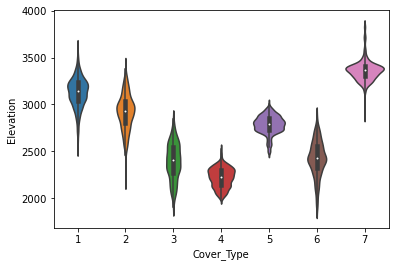

In [5]:
sns.violinplot(x=training_data['Cover_Type'],y=training_data['Elevation'])
plt.show()

Here, we can see there is a relationship between the cover type and elevation. 

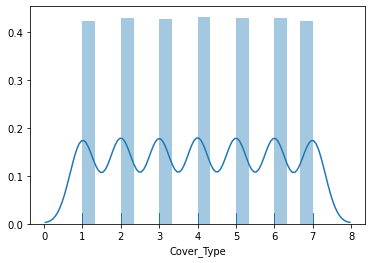

In [6]:
sns.distplot(training_data['Cover_Type'],rug=True)
plt.show()

Here we can see that the training data has a somewhat uniform distribution of covertype and this tells us that our data set is balanced. 

In [7]:
#drop Id column as it is not a meaningful feature.
training_data.drop(columns=["Id"],inplace=True)
dev_data_df.drop(columns=["Id"],inplace=True)
test_df.drop(columns=["Id"],inplace=True)

In [8]:
# Explore correlations between features
train_corr=training_data.corr()
# Rank correlations with "cover type"
train_corr['Cover_Type'].abs().sort_values(ascending=False)

Cover_Type                            1.000000
Soil_Type38                           0.251495
Soil_Type39                           0.240128
Wilderness_Area1                      0.232399
Soil_Type29                           0.220979
Soil_Type40                           0.209668
Soil_Type22                           0.198089
Soil_Type23                           0.155690
Soil_Type12                           0.131788
Soil_Type32                           0.130732
Soil_Type10                           0.122502
Wilderness_Area3                      0.121122
Horizontal_Distance_To_Roadways       0.112399
Soil_Type35                           0.110180
Hillshade_Noon                        0.094449
Horizontal_Distance_To_Fire_Points    0.093196
Soil_Type24                           0.087809
Slope                                 0.086288
Soil_Type33                           0.082439
Soil_Type31                           0.076949
Vertical_Distance_To_Hydrology        0.076230
Wilderness_Ar

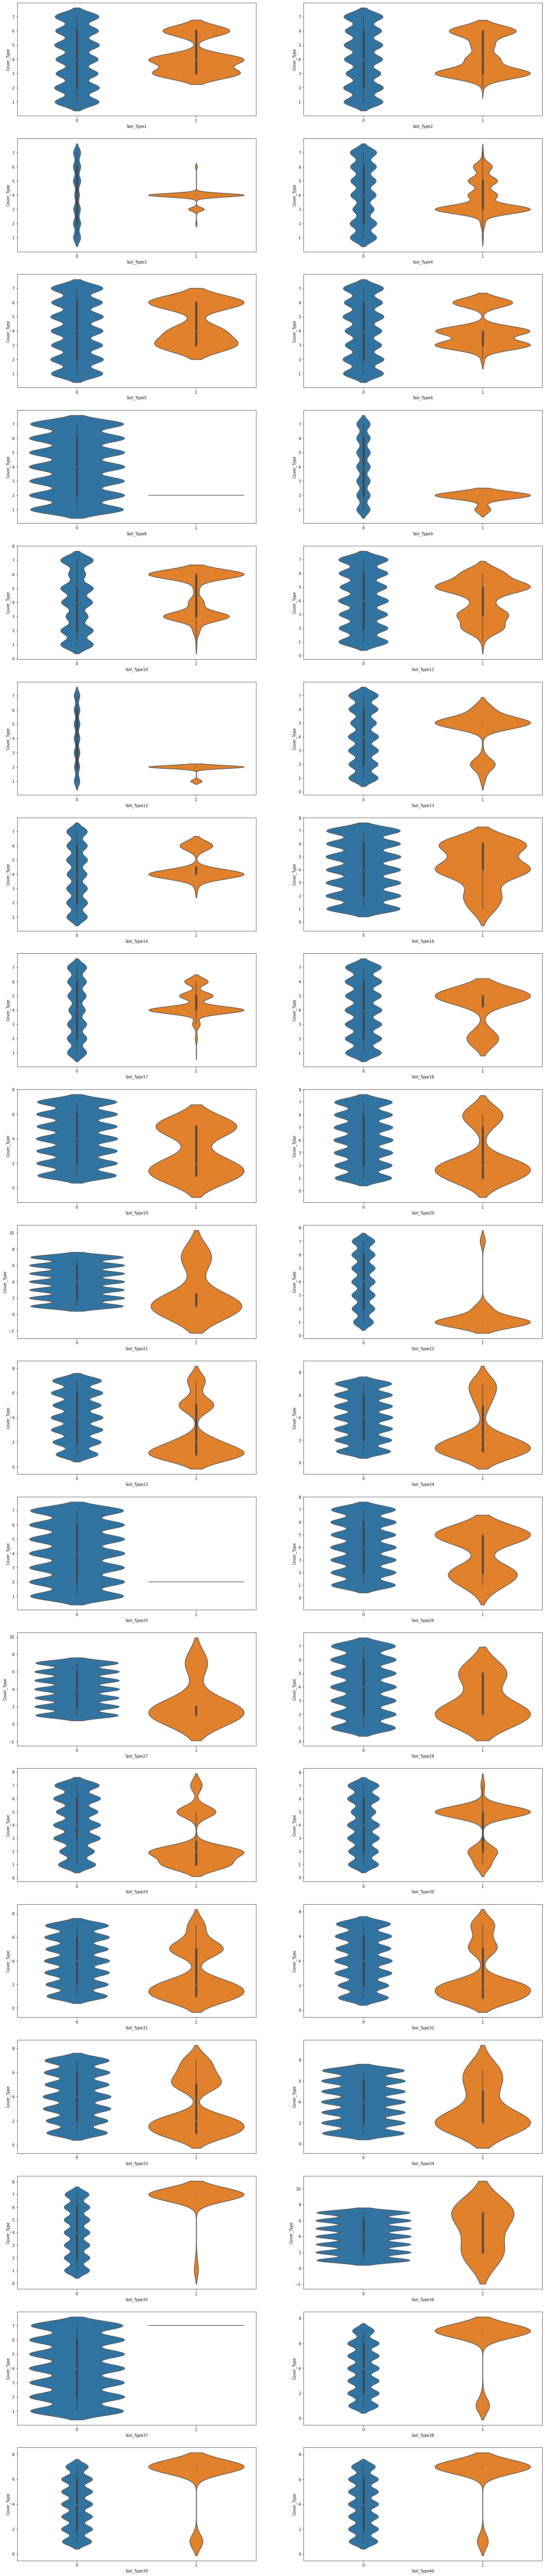

In [9]:
# Visualize the distribution of soil type and "cover type"
st_list = ['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type16','Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']

fig, axes = plt.subplots(19,2,figsize=(24,120))
for i in range(len(st_list)):
    sns.violinplot(y=train_df['Cover_Type'],x=training_data[st_list[i]], ax=axes[i//2,i%2])
plt.show()

Here we can examine the relationship between soil type and cover type for each soil type. # TODO: Discuss more

Now, we'll isolate and explore the distribution of wilderness types. 

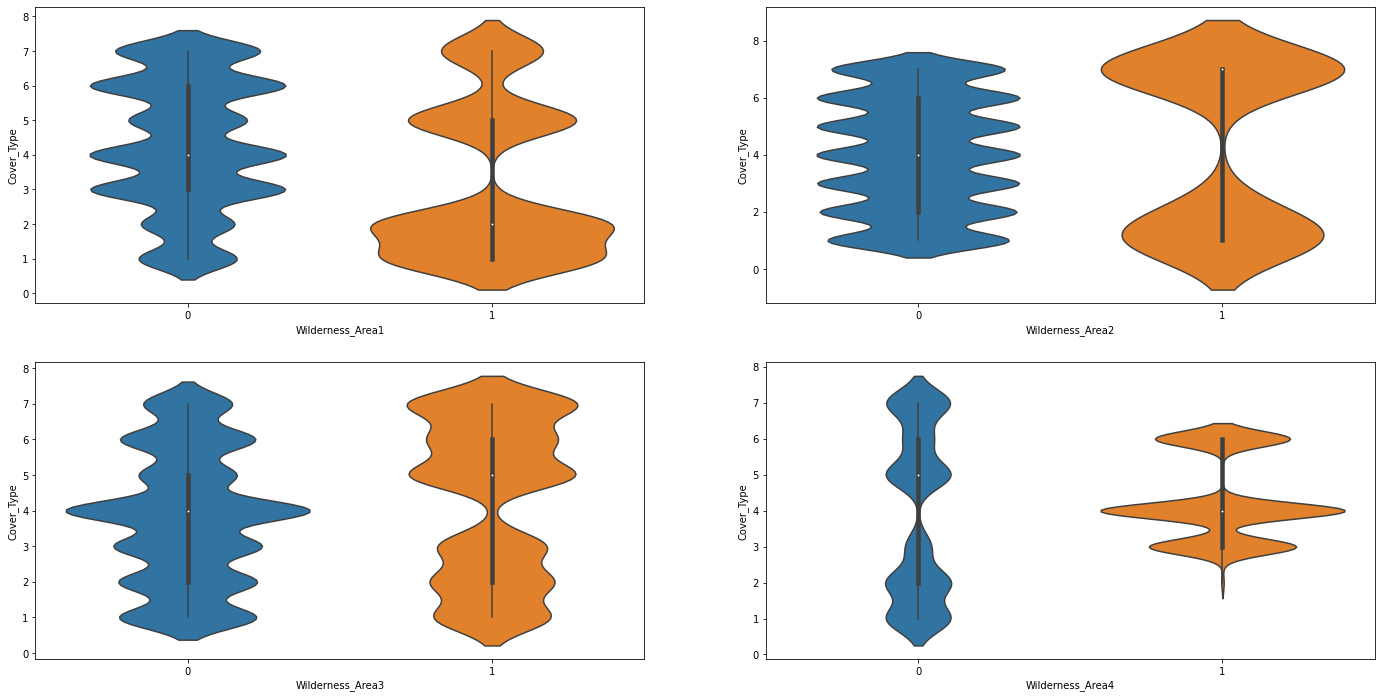

In [10]:
wilderness_list =['Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4']

# Visualize the distribution of wilderness area and "cover type"
fig, axes = plt.subplots(2,2,figsize=(24,12))
for i in range(4):
    sns.violinplot(y=training_data['Cover_Type'],x=training_data[wilderness_list[i]], ax=axes[i//2,i%2])
plt.show()

### Feature Engineering

Now we'll begin modifying both the train and dev data based on our exploratory data analysis. First, we'll drop soil types that don't exist in the training set. Then we will combine soil types 35, 38, 39 and 40 because they have a very similar distribution. 

In [11]:
# Remove soil type 7 and 15 due to no data
training_data.drop(columns=["Soil_Type7", "Soil_Type15"], inplace=True)
dev_data_df.drop(columns=["Soil_Type7", "Soil_Type15"], inplace=True)

# Remove soil type 19, 37, 34, 21, 27,36,9, 28,8,25 due to no limited data - TODO: should we be dropping these? 
training_data.drop(columns=["Soil_Type19", "Soil_Type37","Soil_Type34", "Soil_Type21","Soil_Type27", "Soil_Type36","Soil_Type9", "Soil_Type28","Soil_Type8", "Soil_Type25"], inplace=True)
dev_data_df.drop(columns=["Soil_Type19", "Soil_Type37","Soil_Type34", "Soil_Type21","Soil_Type27", "Soil_Type36","Soil_Type9", "Soil_Type28","Soil_Type8", "Soil_Type25"], inplace=True)

# Combine soil type 35,38,39, 40
training_data["soil_type35383940"] = training_data["Soil_Type38"] +  training_data["Soil_Type39"] + training_data["Soil_Type40"] +  training_data["Soil_Type35"]
training_data.drop(columns=["Soil_Type35","Soil_Type38", "Soil_Type39",'Soil_Type40'], inplace=True)
dev_data_df["soil_type35383940"] = dev_data_df["Soil_Type38"] +  dev_data_df["Soil_Type39"] + dev_data_df["Soil_Type40"] +  dev_data_df["Soil_Type35"]
dev_data_df.drop(columns=["Soil_Type35","Soil_Type38", "Soil_Type39",'Soil_Type40'], inplace=True)

# Check shape is as expected
print(training_data.shape)
print(dev_data_df.shape)

(12096, 40)
(3024, 40)


Additionally, we will scale the training data to have a mean of 0 and a variance of 1. Then we will retrieve the original training mean and variance for each feature and use that to standardize the development data.

In [12]:
# Split into data and labels
train_data = training_data.drop(columns=["Cover_Type"])
train_labels = training_data["Cover_Type"]
dev_data = dev_data_df.drop(columns=["Cover_Type"])
dev_labels = dev_data_df["Cover_Type"]
test_data = test_df

# Double check the shape
print(train_data.shape)
print(dev_data.shape)

(12096, 39)
(3024, 39)


In [13]:
# Collect numeric feature column names - so we can easily access these columns when modifying them 
num_cols = ['Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

# Normalize features using the standard scaler [training data]
scaler = StandardScaler()
norm = scaler.fit(train_data[num_cols])
train_data[num_cols] = norm.transform(train_data[num_cols])
print(train_data.shape)
# Normalize features using the standard scaler [dev data]
dev_data[num_cols] = norm.transform(dev_data[num_cols])
print(dev_data.shape)

# dev_data_minus_mean = dev_data_df[num_cols].sub(scaler.mean_, axis='columns')
# dev_data_standardized = dev_data_minus_mean.div(scaler.var_**(1/2)+1e-05, axis='columns')
# Drop original numeric columns (unstandardized)
# dev_data_df.drop(columns=num_cols, inplace=True)
# Replace with standardized columns
# dev_data_df = dev_data_df.merge(dev_data_standardized, left_index=True, right_index=True, how='left')
# print(dev_data_df.shape)

(12096, 39)
(3024, 39)


"""
Normalize Manually:
- Subtract mean and divide by standard deviation (feature wise) using training data mean/std
- To avoid dividing by 0, add 1e-10 to the standard deviation
- Take the mean on axis 0 (feature wise)
- Reshape it to be a column vector
- Transpose it so we can subtract properly
""" 
train_mean = training_data[num_cols].mean(axis=0)
train_std = training_data[num_cols].std(axis=0)

# Examine mean and std of training data features
print("Mean by Feature:\n", train_mean)
print("\nStandard deviation by Features:\n", train_std)

train_mean = train_mean.values.reshape(-1,1).transpose()
train_std = train_std.values.reshape(-1,1).transpose()

In [14]:
# Double check shape
print(train_data.shape, dev_data.shape)

(12096, 39) (3024, 39)


In [15]:
# Explore and confirm the shape of the data
print("Training data shape: {0} Training labels shape: {1}".format(train_data.shape, train_labels.shape))
print("Dev data shape: {0} Dev labels shape: {1}".format(dev_data.shape, dev_data.shape))
print("Test data shape: ", test_data.shape)

Training data shape: (12096, 39) Training labels shape: (12096,)
Dev data shape: (3024, 39) Dev labels shape: (3024, 39)
Test data shape:  (30000, 54)


In [16]:
# Examine Training Data 
dev_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type26,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,soil_type35383940
1,-0.374445,-0.918116,-1.712056,-0.069025,-0.931658,-0.994752,0.240075,0.703221,0.345697,4.286047,...,0,0,0,0,1,0,0,0,0,0
2,0.138002,-0.164303,-0.886647,0.198966,0.229103,1.117759,0.697108,0.834714,-0.002524,4.191520,...,0,0,0,0,0,0,0,0,0,0
14,-0.582776,-0.000826,-1.476225,-0.762931,-0.768170,-0.779715,0.370656,0.922376,0.345697,3.717975,...,0,0,0,0,0,0,0,0,0,0
16,-0.326553,0.925546,-1.829971,-0.509296,-0.849914,-0.830445,0.109495,0.878545,0.563336,4.168797,...,0,0,0,0,1,0,0,0,0,0
24,-0.573197,-1.226906,-0.886647,-0.509296,-0.604683,-0.735799,0.076849,0.089589,0.171586,3.657987,...,0,0,0,0,0,0,0,0,0,0


## Models
#### Random Forest

Random Forest Performance for 1 trees: 0.580026455026455
Random Forest Performance for 3 trees: 0.7063492063492064
Random Forest Performance for 5 trees: 0.7255291005291006
Random Forest Performance for 10 trees: 0.7318121693121693
Random Forest Performance for 100 trees: 0.7728174603174603


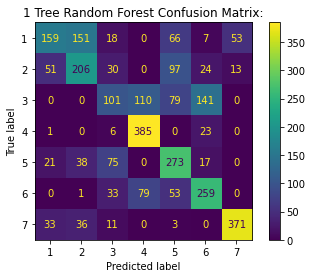

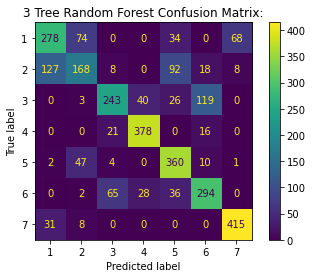

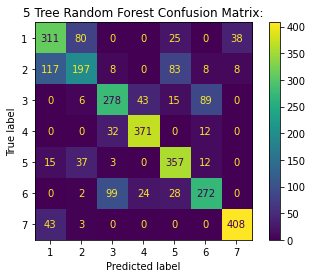

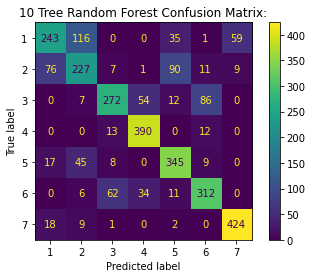

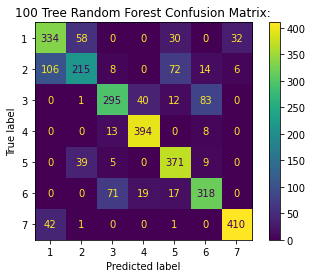

In [17]:
# Try a random forest - before any data cleaning 
def RandomForest(num_trees):
    model = RandomForestClassifier(num_trees,max_depth=8)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    print("Random Forest Performance for {0} trees: {1}".format(num_trees,score))
    # Plot_confusion_matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("{} Tree Random Forest Confusion Matrix:".format(num_trees))
    plt.plot()
    
num_trees_list = [1,3,5,10,100]
for num_trees in num_trees_list:
    RandomForest(num_trees)

#### Naive Bayes (Bernoulli)

BernoulliNB for alph = 0.01: accuracy = 0.6292989417989417





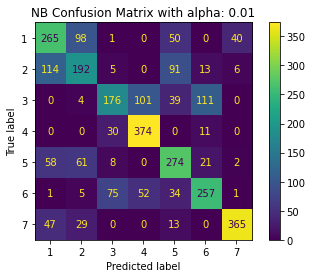

In [18]:
# Try Naive Bayes - before any data cleaning 
def NB(alf):
    model = BernoulliNB(alpha = alf)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    print("BernoulliNB for alph = {0}: accuracy = {1}".format(alf,score))
    # Plot Confusion Matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("NB Confusion Matrix with alpha: {}".format(alf))
    plt.plot()
    print('\n\n')
    
# the alpha isn't actually making a difference 
# alphas_list = [0.00001,0.001, 0.01, 0.1, 1, 10]
alphas_list = [0.01]
for alpha in alphas_list:
    NB(alpha)

#### K-Nearest Neighbors

KNN 1 neighbors : accuracy = 0.8005952380952381
KNN 2 neighbors : accuracy = 0.7800925925925926
KNN 4 neighbors : accuracy = 0.781415343915344
KNN 7 neighbors : accuracy = 0.7662037037037037
KNN 10 neighbors : accuracy = 0.7559523809523809


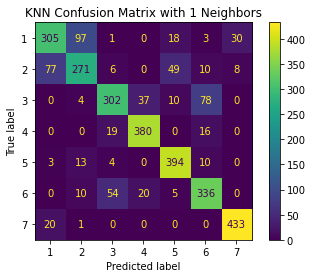

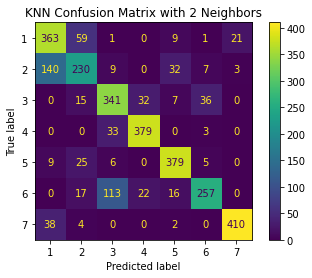

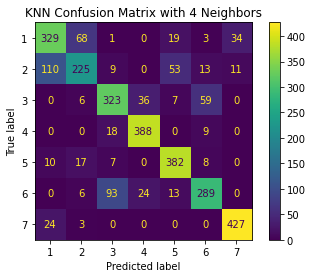

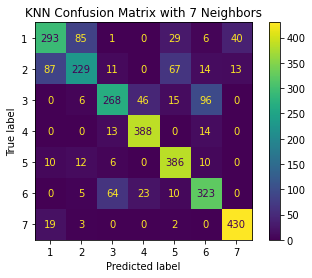

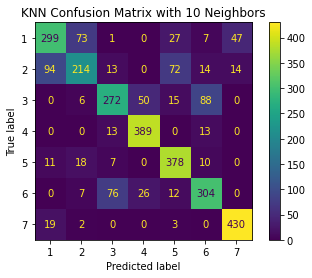

In [19]:
# Try K Nearest Neighbors - before any data cleaning 
def KNN(kn):
    model = KNeighborsClassifier(n_neighbors = kn)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    print("KNN {0} neighbors : accuracy = {1}".format(kn,score))
    # Plot Confusion Matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("KNN Confusion Matrix with {} Neighbors".format(kn))
    plt.plot()
    
# The alpha isn't actually making a difference 
neigh_list = [1,2,4, 7, 10]
for neigh in neigh_list:
    KNN(neigh)

#### Multi-layer Perceptron

In [20]:
# Try Multi-Layer Perceptron - before any data cleaning 
def MLP():
#    model = MLPClassifier(solver='adam', alpha=1e-6, hidden_layer_sizes=(100, ), random_state=0) .8257
#    model = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(100, ), random_state=0)  .82969
#    model = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(200, ), random_state=0) .837
#    model = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(100, ), random_state=0, activation='tanh') .83068

    # Default activation is 'relu', random state lets us get the same result every time (so we can tune other parameters)
    # max_iter is 200 by default, but more helps. alpha is the regularization parameter. solver is 'adam' by default
    model = MLPClassifier(alpha=1e-3, hidden_layer_sizes=(100,), random_state=0, max_iter=300) 
    model.fit(train_data, train_labels) 
    score = model.score(dev_data, dev_labels)
    print("MLP accuracy = ",score)

    
MLP()

MLP accuracy =  0.816468253968254


C:\Users\yjing\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### End matter

#### Acknowledgements/Sources

* That helpful stack overflow post
  * the url for it
* Relevant Documentation
  * KNeighborsClassifier
    * https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
  * Pretty Confusion Matrix
    * https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
  * Preprocessing
    * https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
* Soil information
  * https://www.uidaho.edu/cals/soil-orders/aridisols
  
#### Backup Formats

*because sometimes you just want to look at the markdown or whatever real quick*

In [21]:
#Create a backup of the jupyter notebook in a format for where changes are easier to see.
!jupyter nbconvert clear-cut-solution.ipynb --to="python" --output="backups/clear-cut-solution"
!jupyter nbconvert clear-cut-solution.ipynb --to markdown --output="backups/clear-cut-solution"

# Also archiving this bad boy
!jupyter nbconvert clear-cut-solution.ipynb --to html --output="backups/clear-cut-solution"

[NbConvertApp] Converting notebook clear-cut-solution.ipynb to python
[NbConvertApp] Writing 13912 bytes to backups/clear-cut-solution.py
[NbConvertApp] Converting notebook clear-cut-solution.ipynb to markdown
[NbConvertApp] Support files will be in backups/clear-cut-solution_files\
[NbConvertApp] Making directory backups/clear-cut-solution_files\backups
[NbConvertApp] Making directory backups/clear-cut-solution_files\backups
[NbConvertApp] Making directory backups/clear-cut-solution_files\backups
[NbConvertApp] Making directory backups/clear-cut-solution_files\backups
[NbConvertApp] Making directory backups/clear-cut-solution_files\backups
[NbConvertApp] Making directory backups/clear-cut-solution_files\backups
[NbConvertApp] Making directory backups/clear-cut-solution_files\backups
[NbConvertApp] Making directory backups/clear-cut-solution_files\backups
[NbConvertApp] Making directory backups/clear-cut-solution_files\backups
[NbConvertApp] Making directory backups/clear-cut-solution_